In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <a style=background:yellow;color:black> Preprocessing </a>

In [3]:
train_od = pd.read_csv('../DATA/train_od.csv')

In [4]:
del train_od['Unnamed: 0']

`Date` is the starting date of the case. Notice that each case identifier may have more starting dates (it is obvious if you think that there may be the same case identifier for different cities). 

In [5]:
train_od['Date'] = pd.to_datetime(train_od['Date'])

`Value` is the monetary value of the lawsuit. Example: I got a traffic ticket for speeding of 500€ and I appel to court (the 500€ of the ticket represents the value of the lawsuit). It is formatted as string, we have to remove the 'Euro' and take just the number, moreover, we have to remove the point which in Italy is used to separate the thousands.

In [6]:
taxes_string = np.array(train_od['Value'])

taxes_string_number = [string[5:] for string in taxes_string]

taxes_number = []
for value_string_wrong in taxes_string_number:
    value_string = ''
    for chr_ in value_string_wrong:
        if chr_ != '.' and chr_ != ',':
            value_string += chr_
        elif chr_ == ',':
            value_string += '.'
    taxes_number.append(float(value_string)) # we need to transform the number in float

In [7]:
train_od['Value formatted'] = taxes_number

In [8]:
del train_od['Value']

`Unified Contribution` is the monetary cost for starting the lawsuit. Basically, to start a lawsuit there is the need of a "budget" that is the unified contribution.
The unified contribution depends from the value of the lawsuit. 
The following are the unified contribution tables (of the first lawsuit grade) valid since the 25/06/2014 (first one) and before (second one).

<a style=color:deepskyblue>$$SINCE - 25/06/2014 (First Grade)$$ </a>
<table>
    <tr> <td> Lawsuit value</td> <td> Unified contribution</td> </tr>
    <tr> <td> 0€</td> <td>43€, 237€ and 98€ </td> </tr>
    <tr> <td> 1€-1000€</td> <td> 43€</td> </tr>
    <tr> <td> 1000.01€-1100€</td> <td> 43€</td> </tr>
    <tr> <td> 1100.01€-5200€ </td> <td> 98€</td> </tr>
    <tr> <td> 5200.01€-26000€</td> <td> 237€</td> </tr>
    <tr> <td> 26000.01€-52000€</td> <td> 518€</td> </tr>
    <tr> <td> 52000.01€-260000€</td> <td> 759€</td> </tr>
    <tr> <td> 260000.01€-520000€</td> <td> 1214€</td> </tr>
    <tr> <td> 520000.01€-∞</td> <td> 1686€</td> </tr>
</table>

<a style=color:deepskyblue> $$BEFORE - 25/06/2014 (First Grade)$$</a> 
<table>
    <tr> <td> Lawsuit value</td> <td> Unified contribution</td> </tr>
    <tr> <td> 0€</td> <td>37€, 85€, 206€ and 450€</td> </tr>
    <tr> <td> 1€-1000€</td> <td>37€ </td> </tr>
    <tr> <td> 1000.01€-1100€</td> <td>37€ </td> </tr>
    <tr> <td> 1100.01€-5200€ </td> <td>85€ </td> </tr>
    <tr> <td> 5200.01€-26000€</td> <td>206€ </td> </tr>
    <tr> <td> 26000.01€-52000€</td> <td>450€ </td> </tr>
    <tr> <td> 52000.01€-260000€</td> <td>660€ </td> </tr>
    <tr> <td> 260000.01€-520000€</td> <td>1056€ </td> </tr>
    <tr> <td> 520000.01€-∞</td> <td> 1466€</td> </tr>
</table>

Moreover, this field is formatted as the Value column was formatted, so we have to remove 'Euro' and convert the field as float. It's name will be Unified Contribution formatted.

In [9]:
un_contr_string = train_od['Unified Contribution']

un_contr_string_number =[]
for string in un_contr_string:
    if pd.isna(string)==False:
        un_contr_string_number.append(string[5:])
    else:
        un_contr_string_number.append(pd.NA)

un_contr_number = []
for value_string_wrong in un_contr_string_number:
    value_string = ''
    if pd.isna(value_string_wrong)==False:
        for chr_ in value_string_wrong:
            if chr_ != '.' and chr_ != ',':
                value_string += chr_
            elif chr_ == ',':
                value_string += '.'
        un_contr_number.append(float(value_string)) # we need to transform the number in float
    else:
        un_contr_number.append(pd.NA)


In [10]:
train_od['Unified Contribution formatted'] = un_contr_number
del train_od['Unified Contribution']

#### In the following chunks we create a function which returns the indexes of the rows which are probably anomalies. To do this we check in each row the value of Value formatted. If the value formatted is in a given range, then its Unified Contribution formatted must be in a given range to be a correct value (the tables are shown above: there are two of them because after the 25th June 2014 they changed). If the Unified Contribution is not in that range, then the function append the index in the anomalies_index list. Notice the following things:  

* The NaN are not considered because otherwise pd.NA in [1,2,3] returns an error. We will analyze them separetely.
* We are considering two tables because after the 25th June 2014 they changed.
* We are considering the Value formatted transformed in integers because the values with float are far from the boundaries and so there is no danger that a row ends up in another range when we consider it as int.
* We create also a function (unified_contribution_calculator) which gets the array of the "standard" values of the unified contribution like the ones you've seen in the previous table and returns an array with these values, these values multipled by 0.5, these values multipied by 1.5 and these values multiplied by 2. We did this in order to eliminate just the obvious anomalies.
* We create two different excel files with all the columns of train_s and as rows the anomaly records.

In [11]:
def retrieve_oddness(data, range_table):
        '''
        This function iterates through each row of the data and through each row in range_table and
        if the Value formatted of a row in the data is in a range of the Lawsuit Value, then it is checked also if 
        the Unified Contribution of that row is in the right Unified Contribution range.
        '''
        anomalies_index = []
        
        for row_index_data in range(len(data)):
            for row_index_table in range(len(range_table)):
                if int(data.iloc[row_index_data]['Value formatted']) in range_table.iloc[row_index_table]['Lawsuit Value']:
                    if data.iloc[row_index_data]['Unified Contribution formatted'] not in range_table.iloc[row_index_table]['Unified Contribution']:
                        anomalies_index.append(row_index_data)
                    break # once we find the right row (value-unified contribution) we don't need to check the ones below
                        
        return anomalies_index

In [12]:
def unified_contribution_calculator(in_array):
    out_array = list(in_array*0.5)+list(in_array*1)+list(in_array*1.5)+list(in_array*2)
    return np.sort(np.array(out_array))

The unified_contribution_calculator will be fed with the values of the first grade and the values of the second grade (which are the values of the first grade multiplied by 1.5).

In [13]:
table_range_since_25_06_2014 = pd.DataFrame({
    'Lawsuit Value': [[0],np.arange(1,1101),np.arange(1101,5201),np.arange(5201,26001),np.arange(26001,52001),np.arange(52001,260001),np.arange(260001,520001),np.arange(520001, 3500000)],
    'Unified Contribution' : [unified_contribution_calculator(np.array([43,98,237,259,518,43*1.5,98*1.5,237*1.5,259*1.5,518*1.5])),
                              unified_contribution_calculator(np.array([43,43*1.5])),
                              unified_contribution_calculator(np.array([98,98*1.5])),
                              unified_contribution_calculator(np.array([237,237*1.5])),
                              unified_contribution_calculator(np.array([518,518*1.5])),
                              unified_contribution_calculator(np.array([759,759*1.5])),
                              unified_contribution_calculator(np.array([1214,1214*1.5])),
                              unified_contribution_calculator(np.array([1686,1686*1.5]))]
})

table_range_before_25_06_2014 = pd.DataFrame({
    'Lawsuit Value': [[0],np.arange(1,1101),np.arange(1101,5201),np.arange(5201,26001),np.arange(26001,52001),np.arange(52001,260001),np.arange(260001,520001),np.arange(520001,3500000)],
    'Unified Contribution' : [unified_contribution_calculator(np.array([37,85,206,450,37*1.5,85*1.5,206*1.5,450*1.5])),
                              unified_contribution_calculator(np.array([37,37*1.5])),
                              unified_contribution_calculator(np.array([85,85*1.5])),
                              unified_contribution_calculator(np.array([206,206*1.5])),
                              unified_contribution_calculator(np.array([450,450*1.5])),
                              unified_contribution_calculator(np.array([660,660*1.5])),
                              unified_contribution_calculator(np.array([1056,1056*1.5])),
                              unified_contribution_calculator(np.array([1466,1466*1.5]))]
})

train_od_since_25_06_2014_complete = train_od.loc[train_od['Date']>='2014-06-25'][['ID','Value formatted', 'Unified Contribution formatted']]
train_od_since_25_06_2014_not_NA = train_od_since_25_06_2014_complete.dropna()  
train_od_before_25_06_2014_complete = train_od.loc[train_od['Date']<'2014-06-25'][['ID','Value formatted', 'Unified Contribution formatted']]
train_od_before_25_06_2014_not_NA = train_od_before_25_06_2014_complete.dropna() 

In [14]:
anomalies_index_since_25_06_2014 = retrieve_oddness(train_od_since_25_06_2014_not_NA, table_range_since_25_06_2014)

anomalies_ID_since_25_06_2014 = []

for idx in anomalies_index_since_25_06_2014:
    anomalies_ID_since_25_06_2014.append(train_od_since_25_06_2014_not_NA.iloc[idx]['ID'])

anomalies_index_before_25_06_2014 = retrieve_oddness(train_od_before_25_06_2014_not_NA, table_range_before_25_06_2014)

anomalies_ID_before_25_06_2014 = []

for idx in anomalies_index_before_25_06_2014:
    anomalies_ID_before_25_06_2014.append(train_od_before_25_06_2014_not_NA.iloc[idx]['ID'])

df_anomaly_since_25_06_2014 = train_od.loc[train_od['ID'].isin(anomalies_ID_since_25_06_2014)]
#df_anomaly_since_25_06_2014.to_excel('df_anomaly_since_25_06_2014.xlsx')

df_anomaly_before_25_06_2014 = train_od.loc[train_od['ID'].isin(anomalies_ID_before_25_06_2014)]
#df_anomaly_before_25_06_2014.to_excel('df_anomaly_before_25_06_2014.xlsx')

<a style=color:deepskyblue> After analyzing the anomalies obtained with these function, we've decided to remove them from the data. This because they are just 4706+2298 rows and so it's not worth trying to substitute wrong values with the ones which respect the unified contribution boundaries. Also, we've decided to remove the NA values because we couldn't find a reason why there is no value in there.

In [15]:
anomaly_IDs = list(df_anomaly_since_25_06_2014['ID'])+list(df_anomaly_before_25_06_2014['ID'])

train_od_no_anomaly = train_od.loc[~train_od['ID'].isin(anomaly_IDs)]

#train_od_no_anomaly.to_excel('train_od_no_anomaly.xlsx')

In [16]:
train_od_no_anomaly_NA = train_od_no_anomaly.loc[train_od_no_anomaly['Unified Contribution formatted'].isna()]
to_remove_anomalies = list(df_anomaly_before_25_06_2014['ID'])+list(df_anomaly_since_25_06_2014['ID'])
to_remove_NA = list(train_od_no_anomaly_NA['ID'])
train_od_cleaned = train_od.loc[~train_od['ID'].isin(to_remove_anomalies)]
train_od_cleaned = train_od_cleaned.loc[~train_od_cleaned['ID'].isin(to_remove_NA)]
#train_od_cleaned.to_excel('train_od_cleaned.xlsx')

<a style=color:deepskyblue> From now we are going to use the train_od_cleaned dataset. </a>

`Primary Actor` is the accusing part. There are 110862 NaN values. It is meaningless to check how many are the unique values because they are encripted for privacy reasons.

`Secondary Actor` is always the accusing part. There are 253867 NaN values.

`Primary Defendant` is the defendant of the lawsuit. There are 111328 NaN values.

`Secondary Defendant` is the defendant of the lawsuit. There are 188832 NaN values.

`Number of Lawyers`: lawyers of the actor + lawyers of the defendant

`Number of Legal Parties`:  the number of legal parties involved in the lawsuit

`Number of Persons`: number of attacked people .

`Duration`: How much the lawsuit lasts (in terms of days).

`Outcome`: result of the lawsuit.

Let's analyze the spearman (not linear) correlation between the numerical columns of the dataset.

/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_5539/1802705095.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_num.corr('spearman')


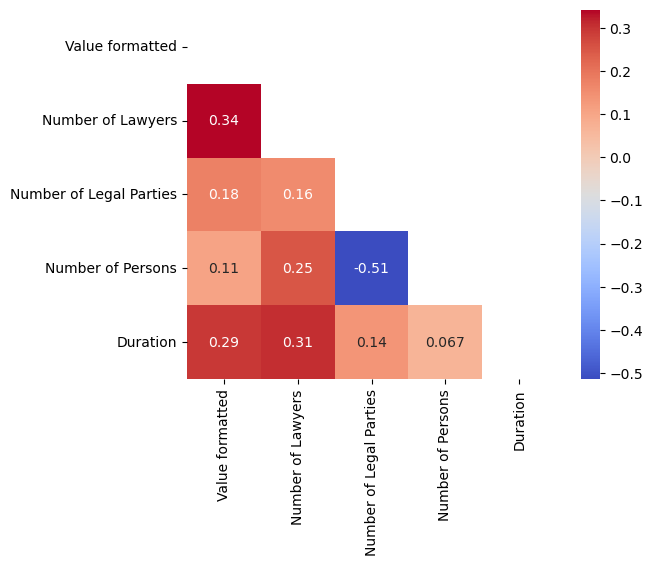

In [20]:
df_num = train_od_cleaned[['Value formatted', 'Unified Contribution formatted', 'Number of Lawyers', 'Number of Legal Parties', 'Number of Persons', 'Duration']]

corr = df_num.corr('spearman')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

dataplot = sns.heatmap(corr, cmap=plt.cm.coolwarm, annot=True,mask=mask, square=True)
plt.show()

<a style=color:deepskyblue> **The last preprocessing steps is to remove the observation where duration is lower than 0** (10963 observations (4% of the overall observations)) </a>.



In [21]:
train_od_cleaned = train_od_cleaned[train_od_cleaned['Duration'] > 0]

In [23]:
del train_od_cleaned['ID']
del train_od_cleaned['Primary Actor']
del train_od_cleaned['Secondary Actor']
del train_od_cleaned['Primary Defendant']
del train_od_cleaned['Secondary Defendant']

In [95]:
#train_od_cleaned.to_excel('final_train_od.xlsx')

In [4]:
data = pd.read_excel('../DATA/final_train_od.xlsx')

In [5]:
del data['Unnamed: 0']

In [6]:
data['Object'].value_counts()

OSA-180002    95668
OR-140999     85055
OR-145009     36160
OR-145999     19870
OSA-180099     7144
OR-139999      3289
OSA-180001     2439
OR-101003      1738
OR-130099       669
OR-130121        28
OR-130131        26
OSA-140999       12
OR-101002         6
OR-180002         5
OR-130111         4
OSA-145999        1
Name: Object, dtype: int64

In [ ]:
cities = []
for city in data['City of the judge’s office'].tolist() :

    if city not in cities : 
        cities.append(city)

for city in cities : 
    data[city] = np.zeros(len(data))

for i in range(len(data)) : 
    data[data['City of the judge’s office'].iloc[i]].iloc[i] = 1

del data['City of the judge’s office']

/var/folders/k1/4fxq2hjd6z7fksrtl6mfqbtc0000gn/T/ipykernel_42734/1278460691.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['City of the judge’s office'].iloc[i]].iloc[i] = 1


In [ ]:
crimes=[]
for crime in data['Object'].tolist() :

    if crime not in crimes : 

        crimes.append(crime)

for crime in crimes : 

    data[crime] = np.zeros(len(data))

for i in range(len(data)) : 

    data[data['Object'].iloc[i]].iloc[i] = 1

In [ ]:
del data['Object']

for i in range(len(data)) : 

    if data['Tax Related'].iloc[i] == True : 

        data['Tax Related'].iloc[i]  = 1 

    else :

        data['Tax Related'].iloc[i] = 0

In [27]:
from datetime import datetime

new_time = datetime.strptime('15/10/2022','%d/%m/%Y')

data['lasture'] = new_time - data['Date']

data['lasture'] = data['lasture'].astype('timedelta64[D]').astype(int)

data = data.loc[data['lasture']>data['Duration']]

del data['lasture']

In [28]:
# data = pd.to_excel('../DATA/final_train_od.xlsx')
# data = pd.read_excel('../DATA/final_train_od.xlsx')

# <a style=background:yellow;color:black> Models <a>

## <a style=background:yellow;color:black> Random forest </a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Carica i dati
X, y = load_data()

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea il modello di random forest
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')

# Addestra il modello
model.fit(X_train, y_train)

# Fai le previsioni sul test set
y_pred = model.predict(X_test)

# Calcola l'f1 score
f1 = f1_score(y_test, y_pred)

print("f1 score:", f1)


## <a style=background:yellow;color:black> Neural Network</a>

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# carica i dati
X = np.load('data_features.npy')
y = np.load('data_labels.npy')

# converte la variabile da predire in numerica
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# divide i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# converte le etichette in formato one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# crea il modello
model = Sequential()
model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# compila il modello
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# addestra il modello
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# effettua le predizioni
y_pred = model.predict(X_test)

# calcola l'f1 score
score = f1_score(y_test, y_pred, average='micro')
print(score)
